In [3]:
import scipy.io
from scipy import stats
import numpy as np
import os
import pandas as pd
import time
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# Translate data into CSV

Load the school file:

In [4]:
file_name = "Caltech36"
input_dir = "/Users/shuozhang/Desktop/Big_Data_Technology/Emerging_Tech_In_Big_Data/Project/facebook100/"
output_dir = "/Users/shuozhang/Desktop/Big_Data_Technology/Emerging_Tech_In_Big_Data/Project/facebook_data/"

In [5]:
file_path = os.path.join(input_dir, file_name + ".mat")
mat = scipy.io.loadmat(file_path)

Friendship matrix: a sparse binary matrix

In [6]:
friendship_matrix = mat['A'].toarray()
friendship_matrix.shape

(769, 769)

Bio matrix: all users in the school

In [9]:
bio_infos = mat['local_info']
print(bio_infos.shape)
column_info = ["student/faculty_status_flag", "gender", "major", "minor", "dorm/house", "year", "high_school"]
df_bio = pd.DataFrame(bio_infos, columns = column_info)
df_bio.index.rename("id", inplace=True)
df_bio

(769, 7)


,student/faculty_status_flag,gender,major,minor,dorm/house,year,high_school
id,,,,,,,
0,1,1,199,0,169,2008,3387
1,1,1,199,0,165,2006,3172
2,1,2,201,0,171,2008,9773
3,2,2,208,210,172,2005,50578
4,1,2,202,0,169,2008,11880
5,1,1,212,0,168,2007,4481
6,1,0,0,0,0,0,0
7,1,2,0,0,171,2008,18258
8,1,0,0,0,0,0,0


Output bio_info table to csv.

In [10]:
bio_file_name = file_name + "_bio.csv"
bio_file_path = os.path.join(output_dir, bio_file_name)
df_bio.to_csv(bio_file_path)

Transform friendship matrix to source-destination pairs (bi-direction, repeat twice) dataframe.

In [11]:
col_name = ["src", "dst", "relationship"]
num_of_users = friendship_matrix.shape[0]
all_pairs = []
for i in range(num_of_users):
    for j in range(num_of_users):
        if i==j:
            continue
        if friendship_matrix[i, j] == 1:
            all_pairs.append([i, j, "friend"])
df_friendship = pd.DataFrame(all_pairs, columns = col_name)

In [12]:
len(all_pairs) / (num_of_users * num_of_users)

0.05633107357434799

Output friendship dataframe to csv.

In [13]:
friend_file_name = file_name + "_friend.csv"
friend_file_path = os.path.join(output_dir, friend_file_name)
df_friendship.to_csv(friend_file_path, index=False)

# Factor Analysis for One School

Get training data from each pair of users: The facotors are whether they have the same column value, and the label is whether they are friends.

In [46]:
num_of_users = friendship_matrix.shape[0]
column_names = ["same_status", "same_gender", "same_dorm", "same_year", "same_high_school", "same_major", "friends"]
training_data = []

start = time.time()
for person_i in range(1, num_of_users):
    for person_j in range(person_i):
        # add factors
        person_i_info = df.iloc[person_i, :]
        person_j_info = df.iloc[person_j, :]
        new_record = []
        for column_index in ["student/faculty_status_flag", "gender", "dorm/house", "year", "high_school"]:
            if person_i_info[column_index] == person_j_info[column_index]:
                new_record.append(1)
            else:
                new_record.append(0)
                
        # add whether they have same major or minor
        if person_i_info["major"] == person_j_info["major"] or person_i_info["major"] == person_j_info["minor"] or person_i_info["minor"] == person_j_info['major'] or person_i_info["minor"] == person_j_info["minor"]:
            new_record.append(1)
        else:
            new_record.append(0)
                
        # add lable
        if friendship_matrix[person_i, person_j] == 1:
            new_record.append(1)
        else:
            new_record.append(0)
            
        # add new row to training data
        training_data.append(new_record)

training_data = pd.DataFrame(training_data, columns = column_names)
print("Number of training data: {}".format(training_data.shape[0]))
end = time.time()
print("{} minutes".format((end - start) / 60))
training_data

Number of training data: 295296
1.9550033211708069 minutes


,same_status,same_gender,same_dorm,same_year,same_high_school,same_major,friends
0,1,1,0,0,0,1,0
1,1,0,0,1,0,1,0
2,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0
6,1,0,1,1,0,1,1
7,1,0,0,0,0,1,0
8,1,1,0,1,0,1,0
9,0,1,0,0,0,0,0


In [47]:
stats.describe(training_data.iloc[:, -1])

DescribeResult(nobs=295296, minmax=(0, 1), mean=0.05640442132639792, variance=0.05322314281781784, skewness=3.8456316364632426, kurtosis=12.788882683366962)

Feed training data into tree classifier feature importance.

{'same_status': 0.16515722177207226, 'same_gender': 0.008598713435790382, 'same_dorm': 0.5181980633532669, 'same_year': 0.23662982562184265, 'same_high_school': 0.05615442222805951, 'same_major': 0.015261753588968372}


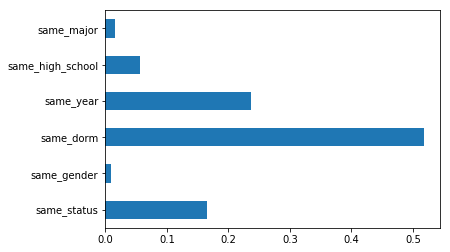

In [58]:
feature_cols = ["same_status", "same_gender", "same_dorm", "same_year", "same_high_school", "same_major"]
X = training_data[feature_cols]
y = training_data.friends
model = ExtraTreesClassifier()
model.fit(X,y)
feature_importance = model.feature_importances_
importance_dict = {}
for i in range(len(feature_cols)):
    importance_dict[feature_cols[i]] = feature_importance[i]
print(importance_dict)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()